In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import math
import matplotlib.pyplot as plt
import time
TRAIN_FILE = 'data/traindata.csv'
TEST_FILE = 'data/testdata.csv'
# smoothing parameter
c = 1.0
# number of classes
k = 2

In [2]:
df = pd.read_csv(TRAIN_FILE,sep=',',header=None)
data = np.array(df)
np.random.shuffle(data)
tdf = pd.read_csv(TEST_FILE,sep=',',header=None)
tdata = np.array(tdf)

In [3]:
# Load train data
ind = np.asarray(data[:,0]).astype(int)
comment = data[:,5]

In [4]:
# Load test data
indices = np.where(tdata[:,0] != 2)[0]
tind = tdata[indices,0]
tcomment = tdata[indices,5]

In [47]:
M = len(comment)
print(M)

1600000


In [48]:
# Calculate phiY and num of both classes
phiY = np.sum(ind)/(4.0*M)  ## y==4
num0 = (1-phiY)*M
num1 = M - num0

### NB without any preprocessing

In [7]:
# generate dictionary of words
dct = {}
for i in range(0,len(comment)):
    words = set(comment[i].split())
    if(ind[i] == 0):
        for w in words:
            if w in dct:
                dct[w][0] += 1
            else:
                dct[w] = [1,0]
    else:
        for w in words:
            if w in dct:
                dct[w][1] += 1
            else:
                dct[w] = [0,1]

In [45]:
# log probab with laplacian smoothing 
def p(x,y):
    occur = [0,0]
    if x in dct:
        occur = dct[x]
    if(y==0):
        return math.log((float)(occur[0]+c)/(float)(num0+(c)));
    else:
        return math.log((float)(occur[1]+c)/(float)(num1+(c)));

In [44]:
def py4x(x):
    p0=0
    p4=0
    for val in x:
        p0 += p(val,0)
        p4 += p(val,4)
    p0 = math.exp(p0)*(1-phiY)
    p4 = math.exp(p4)*(phiY)
    return p4/(p0+p4);

In [87]:
Probabs = [py4x((comm.split())) for comm in tcomment]

In [88]:
def fptp(lim,tY):
    R = np.asarray([4 if (p > lim) else 0 for p in Probabs])
    un = np.where(R!=tind)[0]
    FP = len(np.where(R[un]==4)[0])
    eq = np.where(R==tind)[0]
    TP = len(np.where(R[eq]==4)[0])
    return (TP,FP)

In [89]:
N = 10000

In [90]:
TPs = []
FPs = []
LIM = np.arange(N).astype(float)/float(N)

In [91]:
for lim in LIM:
    (tp,fp) = fptp(lim,tind)
    TPs.append(tp)
    FPs.append(fp)

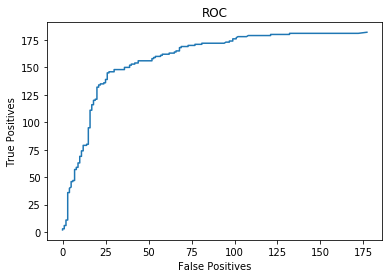

In [92]:
plt.plot(FPs,TPs)
plt.xlabel("False Positives")
plt.ylabel("True Positives")
plt.title("ROC")
plt.savefig("roc.png")

In [95]:
# Testing
Correct = 0.0
cnfmat = np.zeros((2,2)).astype(int)
R = [4 if (py4x(set(comm.split())) > 0.5) else 0 for comm in tcomment]
Correct=len(np.where(R == tind)[0])
# Confusion Matrix
for i in range(0,len(R)):
    cnfmat[R[i]/4][tind[i]/4]+=1
Accuracy = Correct/float(len(tind))
print("Gaussian NB Accuracy: "+str(Accuracy))
print("Confusion Matrix: ")
print(cnfmat)

Gaussian NB Accuracy: 0.805013927577
Confusion Matrix: 
[[154  47]
 [ 23 135]]


### Random Guessing

In [53]:
# part(b) Baseline accuracy
# random guessing
# Theoretically must be 0.5 with very large data set
import random
Correct = 0.0
R = [4 if (random.random() > 0.5) else 0 for v in tcomment]
Correct = len(np.where(R==tind)[0])
Accuracy = Correct/float(len(tind))
print("Random Guess Accuracy: "+str(Accuracy))

Random Guess Accuracy: 0.512534818942


### Majority Class

In [55]:
R = 4* np.ones_like(tind)
Correct = len(np.where(R == tind)[0])
Accuracy = Correct/float(len(tind))
print("Majority Class Prediction Accuracy: "+str(Accuracy))
#equal to the num of majority class present.

Majority Class Prediction Accuracy: 0.506963788301


## Word preprocessing

In [5]:
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import string
import unicodedata
tknzr = TweetTokenizer(strip_handles=True)
ps = nltk.stem.PorterStemmer()
lmt = nltk.stem.WordNetLemmatizer() 
sn = nltk.stem.SnowballStemmer('english')

In [6]:
#preprocessing: returns set of words after processing.
def process(s):
    # remove twitter handle then digits and punctuation
    s = s.decode('latin-1')
    words = set([sn.stem(word.lower()) for word in tknzr.tokenize(s) if word.isalpha() and word not in stopwords.words('english')]) 
    return words
PROCESS = np.vectorize(process)

In [13]:
from multiprocessing import Pool
import time

In [16]:
# ProcessWords
pool = Pool(processes = 8)
st = time.time()
ProcessedComments = pool.map(PROCESS, comment)
pool.close()
pool.join()
print(time.time()-st)

2700.08805203


In [17]:
np.save('processed.npy',ProcessedComments)

In [23]:
ProcessedComments = np.asarray(ProcessedComments)

In [33]:
w=ProcessedComments[0]

{u'come', u'coralin', u'dvd', u'it', u'juli', u'suppos', u'tomorrow'}

In [42]:
# Create Dictionary
dct = {}
st = time.time()
for i in range(0,len(ProcessedComments)):
    words = ProcessedComments[i].item(0)
    if(i%1000==0):
        print(i)
    if(ind[i]==0):
        for w in words:
            if w in dct:
                dct[w][0] += 1;
            else:
                dct[w] = [1,0]
    else:
        for w in words:
            if w in dct:
                dct[w][1] += 1;
            else:
                dct[w] = [0,1]
print(time.time()-st)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


1182000
1183000
1184000
1185000
1186000
1187000
1188000
1189000
1190000
1191000
1192000
1193000
1194000
1195000
1196000
1197000
1198000
1199000
1200000
1201000
1202000
1203000
1204000
1205000
1206000
1207000
1208000
1209000
1210000
1211000
1212000
1213000
1214000
1215000
1216000
1217000
1218000
1219000
1220000
1221000
1222000
1223000
1224000
1225000
1226000
1227000
1228000
1229000
1230000
1231000
1232000
1233000
1234000
1235000
1236000
1237000
1238000
1239000
1240000
1241000
1242000
1243000
1244000
1245000
1246000
1247000
1248000
1249000
1250000
1251000
1252000
1253000
1254000
1255000
1256000
1257000
1258000
1259000
1260000
1261000
1262000
1263000
1264000
1265000
1266000
1267000
1268000
1269000
1270000
1271000
1272000
1273000
1274000
1275000
1276000
1277000
1278000
1279000
1280000
1281000
1282000
1283000
1284000
1285000
1286000
1287000
1288000
1289000
1290000
1291000
1292000
1293000
1294000
1295000
1296000
1297000
1298000
1299000
1300000
1301000
1302000
1303000
1304000
1305000
1306000


In [49]:
# Test data
tProcessedComments = PROCESS(tcomment)
R = [4 if (py4x(tmp) > 0.5) else 0 for tmp in tProcessedComments]
Correct = len(np.where(R == tind)[0])
Accuracy = Correct/float(len(tind))
cnfmat = np.zeros((2,2))
for i in range(0,len(tind)):
    ## confusion matrix
    cnfmat[R[i]/4][tind[i]/4]+=1
print("Gaussian NB with stemming Accuracy: "+str(Accuracy))
print("Confusion Matrix:")
print(cnfmat)

Gaussian NB with stemming Accuracy: 0.785515320334
Confusion Matrix:
[[146.  46.]
 [ 31. 136.]]


### Feature engineering

#### 1. Bi-grams

In [132]:
def getBigrams(s):
    words = list(process(s))
    bigrams = []
#     print(words)
    for i in range(0,len(words)-1):
        bigrams.append(words[i]+" "+words[i+1])
    return set(bigrams+words)
BIGRAM = np.vectorize(getBigrams)

In [138]:
# Use multiprocessing
st = time.time()
pool = Pool(processes=8)
BiGramComments = pool.map(BIGRAM,comment[0:32000])
pool.close()
pool.join()
print(time.time() -st )

In [146]:
np.save('bigram.npy',BiGramComments)

In [143]:
# Create Dictionary
dct = {}
st = time.time()
for words in BiGramComments:
    if(ind[i]==0):
        for w in words:
            if w in dct:
                dct[w][0] += 1;
            else:
                dct[w] = [1,0]
    else:
        for w in words:
            if w in dct:
                dct[w][1] += 1;
            else:
                dct[w] = [0,1]
print(time.time()-st)

0.39226102829


In [140]:
# Test data
tBiGramComments= BIGRAM(tcomment)
R = [4 if (py4x(tmp) > 0.5) else 0 for tmp in tBiGramComments]
Correct = len(np.where(R == tind)[0])
Accuracy = Correct/float(len(tind))
cnfmat = np.zeros((2,2))
for i in range(0,len(tind)):
    ## confusion matrix
    cnfmat[R[i]/4][tind[i]/4]+=1
print("Gaussian NB with stemming Accuracy: "+str(Accuracy))
print("Confusion Matrix:")
print(cnfmat)

Gaussian NB with stemming Accuracy: 0.807799442897
Confusion Matrix:
[[154.  46.]
 [ 23. 136.]]


#### 2. Percentile Selection

In [54]:
percent = 0.5

In [76]:
def getPercentile(s):
    words = np.array(list(process(s)))
    x = words[np.argsort(map(lambda x: len(x), words))]
    n = int((1-percent)*len(words))
    return set(x[n:])
PERCENT = np.vectorize(getPercentile)

In [84]:
# Use multiprocessing
st = time.time()
pool = Pool(processes=8)
TopComments = pool.map(PERCENT,comment[0:4000])
pool.close()
pool.join()
print(time.time() -st)

173.189965963


In [82]:
# Create Dictionary
dct = {}
st = time.time()
for words in TopComments:
    words = words.item(0)
    if(ind[i]==0):
        for w in words:
            if w in dct:
                dct[w][0] += 1;
            else:
                dct[w] = [1,0]
    else:
        for w in words:
            if w in dct:
                dct[w][1] += 1;
            else:
                dct[w] = [0,1]
print(time.time()-st)

0.125473022461


In [83]:
# Test data
tTopComments= PERCENT(tcomment)
R = [4 if (py4x(tmp) > 0.5) else 0 for tmp in tTopComments]
Correct = len(np.where(R == tind)[0])
Accuracy = Correct/float(len(tind))
cnfmat = np.zeros((2,2))
for i in range(0,len(tind)):
    ## confusion matrix
    cnfmat[R[i]/4][tind[i]/4]+=1
print("Gaussian NB with stemming Accuracy: "+str(Accuracy))
print("Confusion Matrix:")
print(cnfmat)

Gaussian NB with stemming Accuracy: 0.518105849582
Confusion Matrix:
[[ 18.  14.]
 [159. 168.]]


In [ ]:
# feature engineering
#1 k-gram 
#2 divide the weight of each word in a sentence ( partial tf-idf? )

## TFIDF

In [151]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.naive_bayes import GaussianNB
import time    
vectorizer = TfidfVectorizer(sublinear_tf=True, stop_words=stopwords.words('english'),decode_error='ignore', encoding='latin-1',ngram_range=(1,3))

In [ ]:
Percentile = 0.01

In [152]:
sp = SelectPercentile(chi2, percentile=Percentile)
clf = GaussianNB()

In [153]:
X = vectorizer.fit_transform(comment).astype(np.float32)

In [154]:
opt = True

In [155]:
if opt:
## Selecting percentiles
    X = sp.fit_transform(X, ind)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/dhull/.local/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/dhull/.local/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/home/dhull/.local/lib/python2.7/site-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/home/dhull/.conda/envs/ocr/lib/python2.7/inspect.py", line 1058, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/home/dhull/.conda/envs/ocr/lib/python2.7/inspect.py", line 1018, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/home/dhull/.conda/envs/ocr/lib/python2.7/inspect.py", line 453, in getsourcefile
    if hasattr(getmodule(object, filename), '__loader__'):
  F

IndexError: string index out of range

In [ ]:
X.get_shape()

In [ ]:
time0 = time.time()
BS = 100
for i in range(0,len(comment)/BS):
    clf.partial_fit(X[i*BS:(i+1)*BS].toarray(),ind[i*BS:(i+1)*BS],classes=[0,4])
time1 = time.time()
print("Total time required = "+str(time1-time0)+"s")

In [ ]:
# Test Data
tX = vectorizer.transform(tcomment)
if opt:
    tX = sp.transform(tX)
print(tX.get_shape())
R = [clf.predict(val.toarray())[0] for val in tX]
Correct = len(np.where(R==tind)[0])
if opt:
    print("Accu")

In [ ]:
print(float(acc)/float(total))

In [ ]:

che.toarray().shape

In [ ]:
clf.predict(vectorizer.transform(['i am saksham','i am not a good']).toarray())

In [ ]:
#tf-idf
dct = {}
for i in range(0,len(comment)):
    if(i%1000==0):
        print(i)
    words = process(comment[i]) ## net non unique also here
    if(ind[i]==0):
        for w in words:
            if w in dct:
                dct[w][0][0] += 1;
            else:
                dct[w] = [[1,0],[0,0]]
        for w in set(words):
            dct[w][0][1]+=1;
    else:
        for w in words:
            if w in dct:
                dct[w][1][0] += 1;
            else:
                dct[w] = [[0,0],[0,1]]
        for w in set(words):
            dct[w][1][1]+=1;


In [ ]:
# print(dct)
tfdct = dct
dct = {}
for w in tfdct:
    d0 = 0.0
    d1 = 0.0
    if(tfdct[w][0][0]!=0):
        d0 = (float)(tfdct[w][0][0])/(float)(tfdct[w][0][1])
    if(tfdct[w][1][0]!=0):
        d1 = (float)(tfdct[w][1][0])/(float)(tfdct[w][1][1])
    dct[w] = [d0,d1]

In [ ]:
dct